In [1]:
%matplotlib inline
from quantecon.lucas_search import LucasSearch
import numpy as np
import matplotlib.pyplot as plt
from quantecon.compute_fp import compute_fixed_point

### Equilibrium Search and Unemployment - Robert Lucas and Edward Prescott - 1974


*Code for the search model. This code calculates the **partial** equilibrium of the model. By partial, I mean that it calculates
the equilibrium for a market that takes economy-wide variables (as the value of searching, $\lambda$) as given.  
It is still necessary to compute the value of searching in order to get the general equilibrium. *

**Model Specifications**

```python
    class LucasSearch(object):
        def __init__(self, beta=.9, states=[1, 2], transition=[[.9, .1], [.1, .9]], lamb=3):
            self.beta = beta
            self.states = states
            self.transition = transition
            self.labour_demand = lambda n, s: (s/2)*(1-.01*n)
            self.grid = np.linspace(1, 100, 100)
            self.lamb = lamb
```
In order to compute the equilibrium, the labour space and the states of the demand have been discretized.  
As usual, **beta** is the discount factor and **transition** is the transition matrix for the states of demand.  
The labour demand function takes the form $R(s,\, n) = s/2\cdot(1-\frac{n}{100})$, where $n$ is the amount of labour employed and $s$ is the state of the demand.  
As this code is computing the *partial* equilibrium, $\lambda$ (**lamb** in the code) is exogenously given.

I selected the default values in order to replicate part of Figure 5 of the paper.

In [2]:
#Instantiating the model with the default specification
ls = LucasSearch()

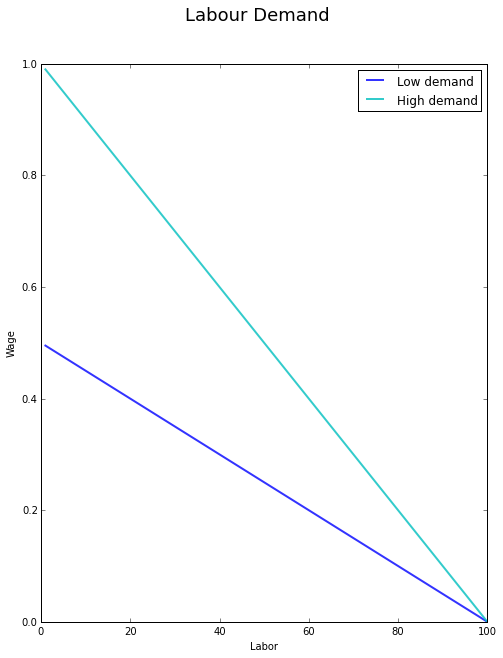

In [3]:
#Plotting the labour demand function
fig, ax = plt.subplots(figsize=(8,10))
ax.set_xlabel("Labor")
ax.set_ylabel("Wage")

wages = [[ls.labour_demand(n, s) for n in ls.grid] for s in ls.states]

ax.plot(ls.grid, wages[0], 'b-', lw = 2, alpha = .8, label = "Low demand")
ax.plot(ls.grid, wages[1], 'c-', lw = 2, alpha = .8, label = "High demand")

ax.legend(loc = 'upper right')

t = 'Labour Demand'
fig.suptitle(t, fontsize=18)

plt.show()

**Computing the value function**

I use the Bellman operator to solve for the following functional equation:  

$$ v(s,\, y,\, \lambda) = max[\lambda,\, R(s,\, n) + min(\lambda,\, \beta E[v(s',\, y',\, \lambda) | s,\, y,\, \lambda])] $$

A little explanation for this value function:

The value function takes the minimum of **case_b1** and **case_b2** because if the future value is too high, it will attract new workers from the rest of the economy until this excess value is wiped and this market is as good as the others.  
The value function takes the maximum of **case_a** and the rest because even if the situation of this market is grim, workers can move to other markets and get $\lambda$. 

```python
    def bellman_operator(self, v):
        Av = [InterpolatedUnivariateSpline(self.grid, v[i], k=3) for i in xrange(len(self.states))]
		Avx = lambda y: np.asarray([function(y) for function in Av]) 
        case_a = self.lamb
		
        Tv = np.asarray([np.empty(len(self.grid))]*len(self.states))
		for i, y in enumerate(self.grid):
			for j, state in enumerate(self.states):
				case_b1 = self.labour_demand(y, state) + self.beta*np.dot(self.transition[j], Avx(i))
                case_b2 = self.labour_demand(y, state) + self.lamb
				
				Tv[j][i] = max(case_a, min(case_b1, case_b2))
		return Tv
```


The following code plots the value function for a worker (not necessarily employed) that finds himself in a market with low/high demand and a workforce of size $y$.

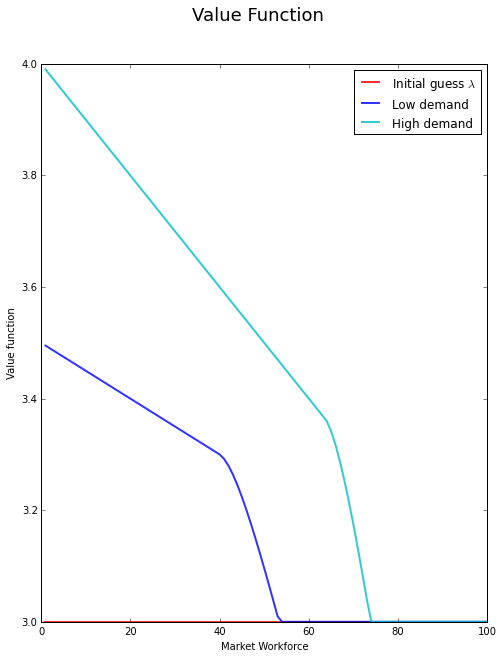

In [4]:
# Expected present value of the wage stream for a worker #
##########################################################

fig, ax = plt.subplots(figsize=(8,10))
ax.set_xlabel("Market Workforce")
ax.set_ylabel("Value function")

v = np.asarray([np.ones(len(ls.grid))*ls.lamb]*len(ls.states))
ax.plot(ls.grid, v[0], 'r-', lw = 2, alpha = .8, label=r'Initial guess $\lambda$')

v_star = compute_fixed_point(ls.bellman_operator, v, verbose=0)
ax.plot(ls.grid, v_star[0], 'b-', lw = 2, alpha = .8, label = "Low demand")
ax.plot(ls.grid, v_star[1], 'c-', lw = 2, alpha = .8, label = "High demand")

ax.legend(loc = 'upper right')

t = 'Value Function'
fig.suptitle(t, fontsize=18)

plt.show()

Clearly, there are three possibilities for the value function.  
At the right-hand side, the value function is equal to $\lambda$ and the market is in **Case A**. This means some workers are leaving and some remain. 
At the left-hand side, the market has a truly low workforce. The demand for labour is higher than the number of workers in the market. In the next period, this market would receive an influx of additional workers from other markets. This is what the authors call **Case B2**.  
At the middle, all the workers in the market are hired. However, unlike **Case B2**, the demand for labour is not so high as to entice outside workers to come to this market. This is what the authors call **Case B1**

**Calculating the Employment rate**

The number of employed workers when the value function is the entire workforce in **Case B1** and **Case B2**. 

However, in **Case A**, not all workers are hired. Since only the hired workers remain for the next period. This means:  

$$ v(s,\, y,\, \lambda) = R(s,\, n) + \beta E[v(s',\, n,\, \lambda) | s,\, y,\, \lambda] = \lambda$$

```python
    def compute_employment(self, v):
		Av = [InterpolatedUnivariateSpline(self.grid, v[i], k=3) for i in xrange(len(self.states))]
		Avx = lambda y: np.asarray([function(y) for function in Av])
		
		n_eq = np.asarray([np.empty(len(self.grid))]*len(self.states))
		
		function = [lambda n, s=state: self.labour_demand(n, s) + 
                                       self.beta*np.dot(self.transition[j], Avx(n)) 
                                       - self.lamb for j, state in enumerate(self.states)] 
			
		for j in xrange(len(self.states)):
			n_solve = fsolve(function[j], self.grid.max()/2) 
			n_eq[j] = np.ones(len(self.grid))*n_solve
			
		for i, y in enumerate(self.grid):
			for j in xrange(len(self.states)):
				n_eq[j][i] = min(n_eq[j][i], y)
		
		return n_eq

```

This function takes the value function and finds the $\widetilde{n}$ that solves the equation above. In particular, Python can achieve that by finding the zero in **function**.

This plot shows the number of employed workers in a market with a high/low state of demand and a workforce of size **y**.

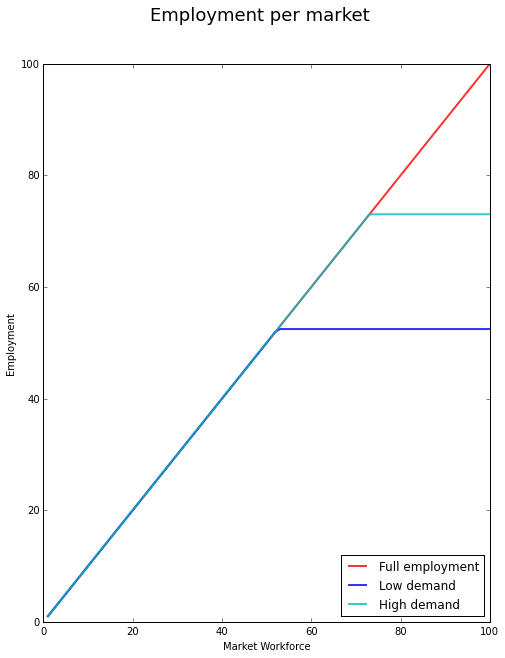

In [5]:
# Employment Plot #
###################

fig, ax = plt.subplots(figsize=(8,10))
ax.set_xlabel("Market Workforce")
ax.set_ylabel("Employment")

employment = ls.compute_employment(v_star)
ax.plot(ls.grid, ls.grid, 'r-', lw = 2, alpha = .8, label = "Full employment")
ax.plot(ls.grid, employment[0], 'b-', lw = 2, alpha = .8, label = "Low demand")
ax.plot(ls.grid, employment[1], 'c-', lw = 2, alpha = .8, label = "High demand")

ax.legend(loc = 'lower right')

t = 'Employment per market'
fig.suptitle(t, fontsize=18)

plt.show()

As we have seen in the last plot, for large values of **y** (large workforces) not all the workers will be hired.

**Why aren't the rest of the workers hired?**

For one, firms cannot hire more workers at the same wage as they are already hiring the optimal amount. The marginal value of labour is already equal to the wage, so hiring a new worker would increase the production by less than his wage. In order to hire more workers, the wage would have to be lower.

However, wages cannot decrease any further. If wages were any lower, workers would prefer to leave their employments and search elsewhere. 

In a nutshell, firms cannot hire more workers at current wages and wages cannot decrease because if they did, employees would rather go search for a job at a different market.

**Unemployment Plot**
This plot shows the number of unemployed workers in a market with a high/low state of demand and a workforce of size **y**.

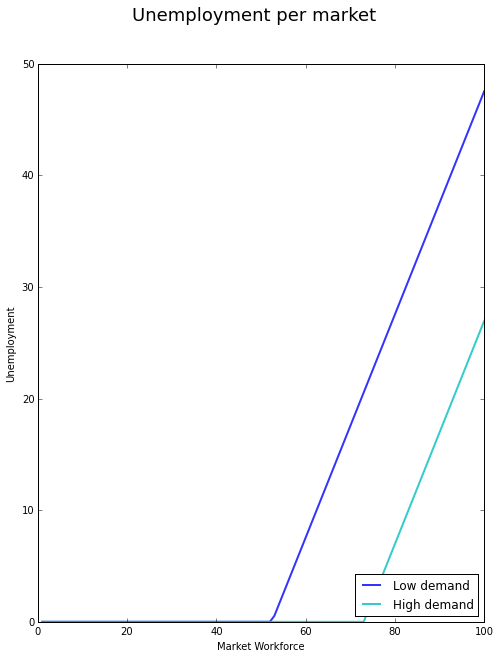

In [6]:
# Unemployment Plot #
#####################

fig, ax = plt.subplots(figsize=(8,10))
ax.set_xlabel("Market Workforce")
ax.set_ylabel("Unemployment")

unemployment= [ls.grid - employment[0], ls.grid - employment[1]] 

ax.plot(ls.grid, unemployment[0], 'b-', lw = 2, alpha = .8, label = "Low demand")
ax.plot(ls.grid, unemployment[1], 'c-', lw = 2, alpha = .8, label = "High demand")

ax.legend(loc = 'lower right')

t = 'Unemployment per market'
fig.suptitle(t, fontsize=18)

plt.show()

This plot shows clearly how markets have an upper bound for the number of workers they can accomodate. Having a workforce that is larger than this upper bound means the excess workers will be unemployed.

**Unemployment rate plot**

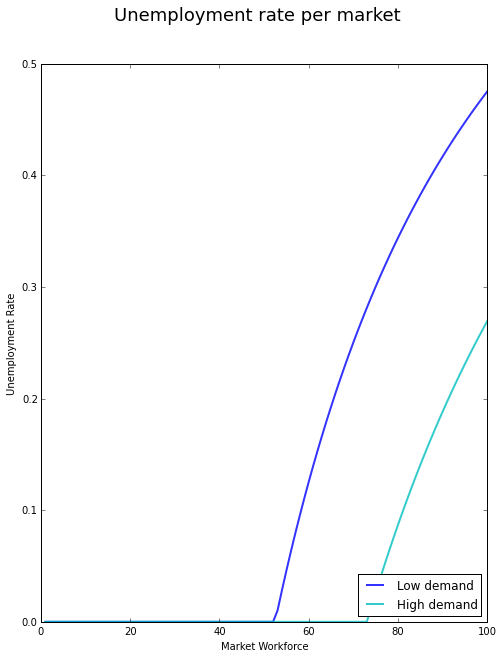

In [7]:
# Unemployment Plot #
#####################

fig, ax = plt.subplots(figsize=(8,10))
ax.set_xlabel("Market Workforce")
ax.set_ylabel("Unemployment Rate")

unemployment_rate = [unemployment[0]/ls.grid, unemployment[1]/ls.grid] 

ax.plot(ls.grid, unemployment_rate[0], 'b-', lw = 2, alpha = .8, label = "Low demand")
ax.plot(ls.grid, unemployment_rate[1], 'c-', lw = 2, alpha = .8, label = "High demand")

ax.legend(loc = 'lower right')

t = 'Unemployment rate per market'
fig.suptitle(t, fontsize=18)

plt.show()